In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os; os.chdir("..")
import pqr
os.chdir("./examples/")

# Загрузка и предобработка данных

In [3]:
prices = pd.read_csv("factors/russia/close_price.csv", parse_dates=True, index_col=0)["2003":]
pe = pd.read_csv("factors/russia/pe.csv", parse_dates=True, index_col=0)["2003":]
volume = pd.read_csv("factors/russia/trading_volume.csv", parse_dates=True, index_col=0)["2003":]
volume = prices * volume  # convert volume from lots to money

prices, pe, volume = pqr.utils.replace_with_nan(prices, pe, volume)

# Строим фактор стоимости и бенчмарк

In [4]:
universe = volume >= 1_000_000
benchmark = pqr.universe_as_benchmark(
    prices=prices,
    universe=universe,
)

In [5]:
table = pqr.utils.partial(
    pqr.metrics.show_table,
    metrics={
        "Monthly Mean Return, %": pqr.metrics.fancy_format(
            pqr.metrics.mean_return,
            multiplier=100,
            statistics=True,
            annualizer=1,
        ),
        "Monthly Volatility, %": pqr.metrics.fancy_format(
            pqr.metrics.volatility,
            multiplier=100,
            annualizer=1,
        ),
        "Maximum Drawdown, %": pqr.metrics.fancy_format(
            pqr.metrics.max_drawdown,
            multiplier=100,
        ),
        "Sharpe Ratio": pqr.metrics.fancy_format(
            pqr.metrics.sharpe_ratio,
            rf=0,
        ),
        "Mean Excess Return, %": pqr.metrics.fancy_format(
            pqr.metrics.mean_excess_return,
            multiplier=100,
            benchmark=benchmark,
        ),
        "Alpha, %": pqr.metrics.fancy_format(
            pqr.metrics.alpha,
            multiplier=100,
            benchmark=benchmark,
            statistics=True,
        ),
        "Beta": pqr.metrics.fancy_format(
            pqr.metrics.beta,
            benchmark=benchmark,
        ),
    }
)
chart = pqr.utils.partial(
    pqr.metrics.plot_chart,
    metrics={
        "Compounded Returns": pqr.metrics.compounded_returns,
    },
    benchmark=benchmark,
    figsize=(16, 9),
)

summary = pqr.utils.partial(
    pqr.metrics.display_dashboard,
    items=[table, chart]
)

In [6]:
mean_transform = pqr.utils.compose(
    pqr.utils.partial(pqr.filter, universe=universe),
    pqr.utils.partial(pqr.look_back_mean, period=3),
    pqr.utils.partial(pqr.hold, period=3),
)
value = mean_transform(pe)

# Конструируем портфель из 50% лучших по фактору стоимости компаний

,Top 50%
"Monthly Mean Return, %",1.59*** (3.17)
"Monthly Volatility, %",7.44
"Maximum Drawdown, %",-66.87
Sharpe Ratio,0.74
"Mean Excess Return, %",2.31
"Alpha, %",2.45 (1.06)
Beta,0.99


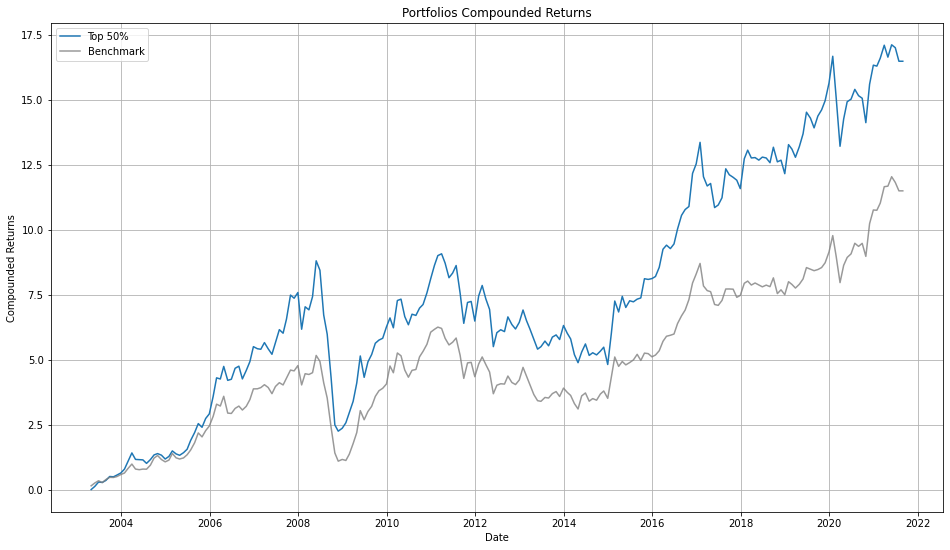

In [7]:
portfolio = pqr.backtest_portfolio(
    prices=prices,
    longs=pqr.quantiles(value, 0, 0.5),
    name="Top 50%"
)

summary([portfolio])

# Пробуем поскейлить

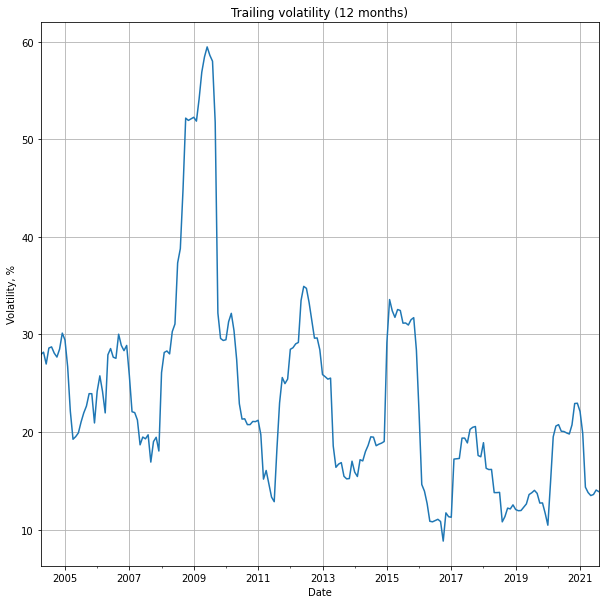

In [8]:
(pqr.metrics.trailing_volatility(portfolio) * 100).plot(figsize=(10, 10))

plt.title("Trailing volatility (12 months)")
plt.xlabel("Date")
plt.ylabel("Volatility, %")
plt.grid();

Волатильность портфеля выглядит неплохо, но видно, что в периоды высокой волатильности (особенно 2008 г.) портфель проигрывает бенчмарку. Попробуем это исправить за счет скейлинга по волатильности.

In [9]:
def volatility_scaling(
    holdings: pd.DataFrame,
    prices: pd.DataFrame,
    target: float,
) -> pd.DataFrame:
    returns = pqr.calculate_returns(prices, holdings)["returns"]
    volatility = pqr.metrics.trailing_volatility(returns)
    
    w, vol = pqr.utils.align(holdings, volatility)
    vol_df = pd.DataFrame(
        np.ones_like(w) * vol.to_numpy()[:, np.newaxis],
        index=w.index,
        columns=w.columns,
    )
    
    return pqr.factor_scaling(
        holdings,
        factor=vol_df,
        target=target,
    )

In [10]:
portfolio_scaled = pqr.backtest_portfolio(
    prices=prices,
    longs=pqr.quantiles(value, 0, 0.5),
    allocation=pqr.utils.compose(
        pqr.equal_weights,
        pqr.utils.partial(
            volatility_scaling,
            prices=prices,
            target=0.2
        )
    ),
    name="Top 50% (scaled)",
)

Посмотрим на получившееся плечо портфеля.

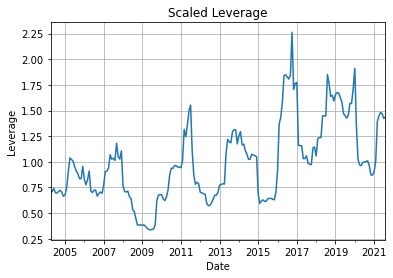

In [11]:
portfolio_scaled.drop(columns=["returns"]).sum(axis=1).plot()

plt.title("Scaled Leverage")
plt.xlabel("Date")
plt.ylabel("Leverage")
plt.grid();

,Top 50%,Top 50% (scaled)
"Monthly Mean Return, %",1.59*** (3.17),1.18*** (2.61)
"Monthly Volatility, %",7.44,6.55
"Maximum Drawdown, %",-66.87,-45.80
Sharpe Ratio,0.74,0.62
"Mean Excess Return, %",2.31,0.62
"Alpha, %",2.45 (1.06),3.64 (1.17)
Beta,0.99,0.78


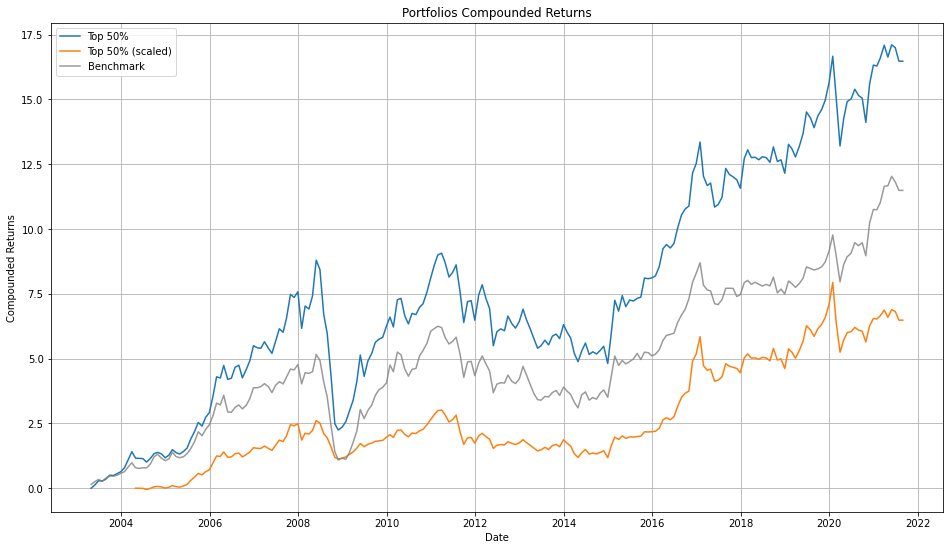

In [12]:
summary([portfolio, portfolio_scaled])

Стало хуже, потому что в 2008 году пришлось понижать плечо слишком поздно, за счет чего не был пойман отскок рынка (зато падение поймали отлично), а в 2017 году на экстремально низкой волатильности портфеля было повышено плечо очень сильно, что привело к большим потерям. Попробуем ограничить плечо.

In [13]:
portfolio_scaled_limits = pqr.backtest_portfolio(
    prices=prices,
    longs=pqr.quantiles(value, 0, 0.5),
    allocation=pqr.utils.compose(
        pqr.equal_weights,
        pqr.utils.partial(
            volatility_scaling,
            prices=prices,
            target=0.2
        ),
        pqr.utils.partial(
            pqr.limit_leverage,
            min_leverage=0.8,
            max_leverage=1.5,
        )
    ),
    name="Top 50% (scaled)"
)

Видно, что теперь не позволяем портфелю быть заполненным менее чем на 80%, но плечо ограничиваем в 1.2

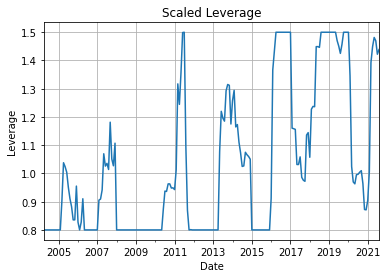

In [14]:
portfolio_scaled_limits.drop(columns=["returns"]).sum(axis=1).plot()

plt.title("Scaled Leverage")
plt.xlabel("Date")
plt.ylabel("Leverage")
plt.grid();

Но сильно лучше не стало: хотя в 2017 ушла такая бешеная волатильность портфеля, после 2008 оставание никуда не делось.

,Top 50%,Top 50% (scaled),Top 50% (scaled)
"Monthly Mean Return, %",1.59*** (3.17),1.18*** (2.61),1.22*** (2.53)
"Monthly Volatility, %",7.44,6.55,6.99
"Maximum Drawdown, %",-66.87,-45.80,-57.57
Sharpe Ratio,0.74,0.62,0.61
"Mean Excess Return, %",2.31,0.62,1.08
"Alpha, %",2.45 (1.06),3.64 (1.17),2.32 (0.92)
Beta,0.99,0.78,0.91


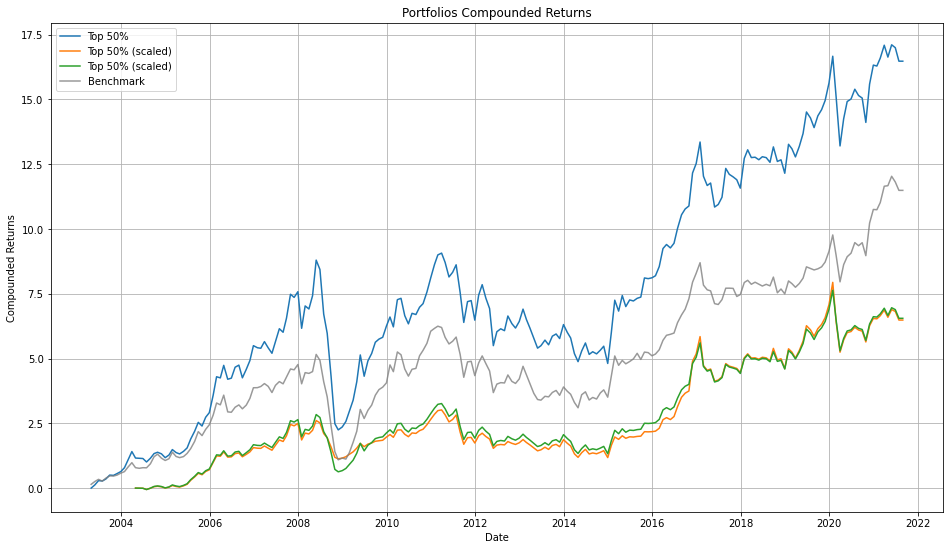

In [15]:
summary([portfolio, portfolio_scaled, portfolio_scaled_limits])